# 15-122 OH Queue Wait Time Estimator

Being former 15-122 students, and one of beung a current TA, 15-122 is a course that is very close to our hearts. Over the course of last semester however, we observed that the wait time prediction that the 122 OH Queue tries to do is pretty inaccurate. 

![chart](chart2.png)

In this particular case, the TAs had actually managed to clear the queue in less than an hour!

We decided to fix this. Fortunately, the 122 staff collects tons of data during its OH about a student's wait time, help time, topic id of question etc. We got access to this data for a semester and decided to use  a machine learning model to try to to  predict a particular student's estimated help  time. We would then use the estimated help times of all the students being helped currently to get an estimate of the wait time for a student entering the queue.  The ad hoc algorithm converting estimated help times to wait times already  exists within the 122 infrastructure and the only issue was the help time predictions themselves. 


Our data pipeline was as follows- 
1. Obtaining and cleaning data (Data is far from ideal and contains several flaws)
2. Visualizing the data (To figure out f machine learning is feasible and the model to use)
3. Creating and training the Model (We ended up using a GLM) 
4. Fine-tuning hyper-parameters, the size of prediction bins in our case, using cross-validation.

We also created a fun game at the end to allow the user to compete with our model. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import random

## Obtaining and cleaning data

In [18]:
df = pd.read_csv("entries.csv")
topics = pd.read_csv("topics.csv")

In [19]:
print(len(df))
print(df.head())
print(topics.head())

17067
   id                            andrew_id_hash semester           entry_time  \
0   1  5660915b416b110d3125eddaf15d004c09f2dcf9      S17  2017-01-18 16:30:42   
1   2  7a3ff1726a9e59878e74b78b612e705ba388f35c      S17  2017-01-18 16:30:47   
2   3  33573dcedddbc5924f4fc0c16db8b901fd1c8286      S17  2017-01-18 16:31:00   
3   4  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67      S17  2017-01-18 16:31:09   
4   5  9a08eb5de601714dce83c7c7e5040509349f512c      S17  2017-01-18 16:32:51   

             help_time            exit_time  wait_estimate  topic_id  ta_id  
0  2017-01-18 16:31:36  2017-01-18 16:31:39            NaN       5.0      8  
1  2017-01-18 16:31:44  2017-01-18 16:34:53            NaN       4.0     22  
2  2017-01-18 16:32:12  2017-01-18 16:33:05            NaN       4.0     17  
3  2017-01-18 16:32:28  2017-01-18 16:38:52            NaN       4.0     16  
4  2017-01-18 16:33:15  2017-01-18 16:39:42            0.0       1.0     17  
   id             name       out_date  


As is visible, for each query made at Office Hours, we have the Andrew ID of the student (hashed), the entry time, the help time (time at which a TA started helping the student), the exit time (time at which the TA finished helping the student), the estimated wait time, the topic ID, the TA ID etc.  A lot of the rows also have NaNs interspersed. 

We also have 'topics data-frame' with all the topics and unique ids from the last 4 years. 

The features important to us are solely the help time, the Andrew ID and the Topic IDs. Thus, we first remove the unimportant columns and then compute the time the student was helped. 


In [20]:
df2 = df.drop(['wait_estimate', 'ta_id', 'id', 'semester'], axis=1)
df2 = df2.dropna(axis=0, how='any')


In [21]:
topics = topics.drop(['out_date', 'due_date', 'semester'], axis=1)
print(topics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
id      120 non-null int64
name    120 non-null object
dtypes: int64(1), object(1)
memory usage: 2.0+ KB
None


In [22]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16062 entries, 0 to 17066
Data columns (total 5 columns):
andrew_id_hash    16062 non-null object
entry_time        16062 non-null object
help_time         16062 non-null object
exit_time         16062 non-null object
topic_id          16062 non-null float64
dtypes: float64(1), object(4)
memory usage: 752.9+ KB
None


In [23]:
df2['entry_time'] = pd.to_datetime(df2['entry_time'])
df2['help_time'] = pd.to_datetime(df2['help_time'])
df2['exit_time'] = pd.to_datetime(df2['exit_time'])
df2['topic_id'] = df2['topic_id'].astype(int)

In [24]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16062 entries, 0 to 17066
Data columns (total 5 columns):
andrew_id_hash    16062 non-null object
entry_time        16062 non-null datetime64[ns]
help_time         16062 non-null datetime64[ns]
exit_time         16062 non-null datetime64[ns]
topic_id          16062 non-null int32
dtypes: datetime64[ns](3), int32(1), object(1)
memory usage: 690.2+ KB
None


In [25]:
df2['WT'] = (df2['help_time'] - df2['entry_time']).astype('timedelta64[s]').astype(int)
df2['HT'] = (df2['exit_time'] - df2['help_time']).astype('timedelta64[s]').astype(int)

Here, we calculate a student's actual help time (HT) and wait time (WT) 

In [26]:
df3 = df2[['andrew_id_hash', 'WT', 'HT', 'topic_id']]
print(df3.info())
print(df3.head())
print(topics.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16062 entries, 0 to 17066
Data columns (total 4 columns):
andrew_id_hash    16062 non-null object
WT                16062 non-null int32
HT                16062 non-null int32
topic_id          16062 non-null int32
dtypes: int32(3), object(1)
memory usage: 1.1+ MB
None
                             andrew_id_hash  WT   HT  topic_id
0  5660915b416b110d3125eddaf15d004c09f2dcf9  54    3         5
1  7a3ff1726a9e59878e74b78b612e705ba388f35c  57  189         4
2  33573dcedddbc5924f4fc0c16db8b901fd1c8286  72   53         4
3  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67  79  384         4
4  9a08eb5de601714dce83c7c7e5040509349f512c  24  387         1
   id             name
0   1    setup (Linux)
1   2         written1
2   3         scavhunt
3   4      setup (Mac)
4   5  setup (Windows)


Finally, our data is ready (Almost). We still need to do 2 things:
1. Remove the outliers (probably not actual records and were not entered correctly)
2. Join the topic ID in the dataset with the topic ID in the topic dataset. (We need to do this because some topics have different ids, for example the topic C0VM has 4 different ids: one for each semester the assignment was given!)

### 1. Removing outliers

In [27]:
df3 = df3.where(df3['HT'] > 30).dropna()
df3 = df3.where(df3['HT'] < 2700).dropna()
print(len(df3))

15533


### 2. Merging with the topic list

In [28]:
df4 = df3.merge(topics, left_on='topic_id', right_on='id')
df4 = df4.drop(['topic_id', 'id'], axis=1)
df4['WT'] = df4['WT'].astype(int)
df4['HT'] = df4['HT'].astype(int)
print(df4.head())
print(len(df4))

                             andrew_id_hash   WT   HT         name
0  7a3ff1726a9e59878e74b78b612e705ba388f35c   57  189  setup (Mac)
1  33573dcedddbc5924f4fc0c16db8b901fd1c8286   72   53  setup (Mac)
2  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67   79  384  setup (Mac)
3  9bf345f89e209ba0c0cf5ffb6a450669fdc96910  116   61  setup (Mac)
4  8098b7df9506a418f44cbf339a82d59f8c4b0391  126  145  setup (Mac)
15533


In [29]:
topiclist = df4['name'].unique()
print(topiclist)

['setup (Mac)' 'setup (Linux)' 'setup (Windows)' 'written1' 'scavhunt'
 'written2' 'pixels' 'written3' 'images' 'written4' 'doslingos'
 'images style' 'written5' 'midterm1' 'written6' 'clac-exp' 'written7'
 'tbuf' 'exp style' 'written8' 'bloom' 'written9' 'ropes' 'written10'
 'queues' 'written11' 'lightsout' 'written12' 'c0vm' 'written13' 'speller'
 'exam1' 'clac' 'exam3' 'editor-check' 'editor' 'midterm2' 'strbuf'
 'huffman' 'final']


Now that we have linked the topic ids in our dataset with the topic IDs in the topic dataset, we also decide to combine the topics that are similar: we merge all the written assignments and style issues and pre-exam questions

We do this because these are very similar topics and take a fairly standard amount of help time. 

In [30]:
topicmap = {}
for topic in topiclist:
    if (topic[:7] == 'written'):
        topicmap[topic] = 'written'
    elif (topic[-5:] == 'style'):
        topicmap[topic] = 'style'
    elif (topic == 'midterm1' or topic == 'midterm2' or topic == 'final' or topic == 'exam1' or topic == 'exam2' or topic == 'exam3'):
        topicmap[topic] = 'exam'
    else:
        topicmap[topic] = topic

In [31]:
df4['new_id'] = df4['name'].apply(lambda x : topicmap[x])
df5 = df4.drop(['name'], axis=1)
print(df5['new_id'].unique())
print(df5.head())

['setup (Mac)' 'setup (Linux)' 'setup (Windows)' 'written' 'scavhunt'
 'pixels' 'images' 'doslingos' 'style' 'exam' 'clac-exp' 'tbuf' 'bloom'
 'ropes' 'queues' 'lightsout' 'c0vm' 'speller' 'clac' 'editor-check'
 'editor' 'strbuf' 'huffman']
                             andrew_id_hash   WT   HT       new_id
0  7a3ff1726a9e59878e74b78b612e705ba388f35c   57  189  setup (Mac)
1  33573dcedddbc5924f4fc0c16db8b901fd1c8286   72   53  setup (Mac)
2  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67   79  384  setup (Mac)
3  9bf345f89e209ba0c0cf5ffb6a450669fdc96910  116   61  setup (Mac)
4  8098b7df9506a418f44cbf339a82d59f8c4b0391  126  145  setup (Mac)


In [32]:
print(df5['new_id'].value_counts())

written            3945
c0vm               1758
ropes              1024
lightsout          1022
style               709
queues              701
images              697
bloom               651
tbuf                570
pixels              555
clac-exp            504
doslingos           493
exam                428
huffman             420
strbuf              352
clac                342
speller             321
scavhunt            290
editor              236
setup (Mac)         230
editor-check        154
setup (Windows)     120
setup (Linux)        11
Name: new_id, dtype: int64


In [33]:
print(len(df5['andrew_id_hash'].value_counts().where(df5['andrew_id_hash'].value_counts() > 0).dropna()))
print(len(df5['andrew_id_hash'].value_counts().where(df5['andrew_id_hash'].value_counts() > 1).dropna()))
print(len(df5['andrew_id_hash'].value_counts().where(df5['andrew_id_hash'].value_counts() > 20).dropna()))

1003
757
209


Note that there's relatively few students who show up more than 20 times. 

## Visualization

We now move on to visualizing our cleaned up data. 

If we focus on exact values for the topics or the andrew IDs and we plot of a histogram of the help times, we get plots that look like poisson distributions.

(array([361., 502., 464., 431., 319., 296., 253., 217., 166., 130., 117.,
         87.,  97.,  81.,  60.,  47.,  34.,  40.,  34.,  20.,  26.,  20.,
         14.,  19.,  18.,  10.,  16.,  10.,   5.,   5.,   2.,   5.,   9.,
          5.,   6.,   2.,   4.,   1.,   4.,   2.,   0.,   1.,   1.,   0.,
          1.,   1.,   0.,   1.,   0.,   1.]),
 array([  31.  ,   83.82,  136.64,  189.46,  242.28,  295.1 ,  347.92,
         400.74,  453.56,  506.38,  559.2 ,  612.02,  664.84,  717.66,
         770.48,  823.3 ,  876.12,  928.94,  981.76, 1034.58, 1087.4 ,
        1140.22, 1193.04, 1245.86, 1298.68, 1351.5 , 1404.32, 1457.14,
        1509.96, 1562.78, 1615.6 , 1668.42, 1721.24, 1774.06, 1826.88,
        1879.7 , 1932.52, 1985.34, 2038.16, 2090.98, 2143.8 , 2196.62,
        2249.44, 2302.26, 2355.08, 2407.9 , 2460.72, 2513.54, 2566.36,
        2619.18, 2672.  ]),
 <a list of 50 Patch objects>)

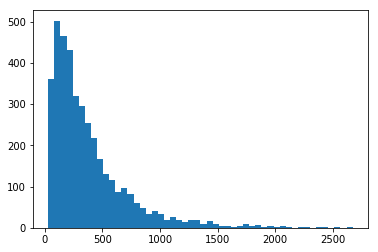

In [34]:
writtens = df5['HT'].where(df5['new_id'] == 'written').dropna()
plt.hist(writtens, bins=50)

(array([ 79., 118., 137., 153., 132., 100., 122., 106.,  75.,  75.,  75.,
         54.,  51.,  64.,  47.,  43.,  35.,  23.,  33.,  19.,  20.,  20.,
         18.,  17.,   9.,  18.,  10.,   9.,  12.,  13.,   2.,   9.,   7.,
          4.,   2.,   1.,   7.,   5.,   2.,   3.,   2.,   3.,   2.,   5.,
          4.,   4.,   1.,   4.,   2.,   2.]),
 array([  31.  ,   83.96,  136.92,  189.88,  242.84,  295.8 ,  348.76,
         401.72,  454.68,  507.64,  560.6 ,  613.56,  666.52,  719.48,
         772.44,  825.4 ,  878.36,  931.32,  984.28, 1037.24, 1090.2 ,
        1143.16, 1196.12, 1249.08, 1302.04, 1355.  , 1407.96, 1460.92,
        1513.88, 1566.84, 1619.8 , 1672.76, 1725.72, 1778.68, 1831.64,
        1884.6 , 1937.56, 1990.52, 2043.48, 2096.44, 2149.4 , 2202.36,
        2255.32, 2308.28, 2361.24, 2414.2 , 2467.16, 2520.12, 2573.08,
        2626.04, 2679.  ]),
 <a list of 50 Patch objects>)

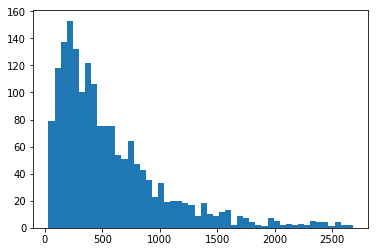

In [35]:
c0vm = df5['HT'].where(df5['new_id'] == 'c0vm').dropna()
plt.hist(c0vm, bins=50)

(array([17., 17., 23., 25., 25., 28., 23., 15., 24., 19., 16.,  8., 15.,
        14., 19., 12., 15.,  6.,  8., 11.,  7.,  6.,  7.,  7.,  4.,  4.,
         5.,  3.,  4.,  3.,  2.,  4.,  2.,  4.,  3.,  2.,  1.,  4.,  2.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,  0.,  2.]),
 array([  40.  ,   91.54,  143.08,  194.62,  246.16,  297.7 ,  349.24,
         400.78,  452.32,  503.86,  555.4 ,  606.94,  658.48,  710.02,
         761.56,  813.1 ,  864.64,  916.18,  967.72, 1019.26, 1070.8 ,
        1122.34, 1173.88, 1225.42, 1276.96, 1328.5 , 1380.04, 1431.58,
        1483.12, 1534.66, 1586.2 , 1637.74, 1689.28, 1740.82, 1792.36,
        1843.9 , 1895.44, 1946.98, 1998.52, 2050.06, 2101.6 , 2153.14,
        2204.68, 2256.22, 2307.76, 2359.3 , 2410.84, 2462.38, 2513.92,
        2565.46, 2617.  ]),
 <a list of 50 Patch objects>)

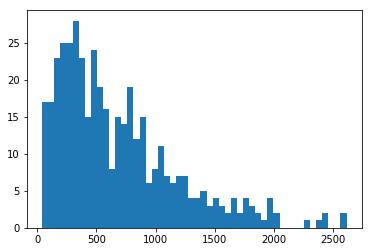

In [36]:
huffman = df5['HT'].where(df5['new_id'] == 'huffman').dropna()
plt.hist(huffman, bins=50)

(array([30., 38., 44., 34., 40., 25., 26., 10., 12.,  5.,  8.,  7.,  5.,
         4.,  2.,  4.,  1.,  0.,  1.,  1.]),
 array([  39.  ,  167.35,  295.7 ,  424.05,  552.4 ,  680.75,  809.1 ,
         937.45, 1065.8 , 1194.15, 1322.5 , 1450.85, 1579.2 , 1707.55,
        1835.9 , 1964.25, 2092.6 , 2220.95, 2349.3 , 2477.65, 2606.  ]),
 <a list of 20 Patch objects>)

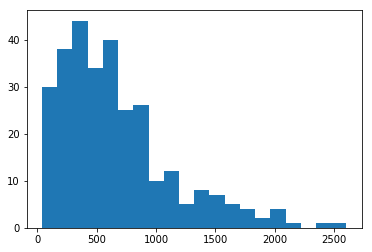

In [37]:
helpthispersonpls297 = df5['HT'].where(df5['andrew_id_hash'] == '21cb1f9adbacb7cf4bfb15085966652648310c05').dropna()
plt.hist(helpthispersonpls297, bins=20)

(array([2., 0., 1., 2., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([ 33. ,  50.7,  68.4,  86.1, 103.8, 121.5, 139.2, 156.9, 174.6,
        192.3, 210. , 227.7, 245.4, 263.1, 280.8, 298.5, 316.2, 333.9,
        351.6, 369.3, 387. ]),
 <a list of 20 Patch objects>)

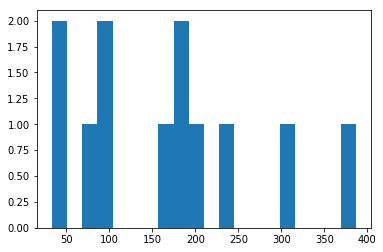

In [38]:
helpthispersonpls12 = df5['HT'].where(df5['andrew_id_hash'] == '8062624b2a0e63429aec70cb1f934fee704435ef').dropna()
plt.hist(helpthispersonpls12, bins=20)

This looked promising, so we tried to make a small game to see if we could predict help times ourselves using the features we had decided on.

In [39]:
def game():
    
    record = df5.sample()
    andrew = record['andrew_id_hash'].to_string(header=False, index=False)
    ht = int(record['HT'].to_string(header=False, index=False))
    new_id = record['new_id'].to_string(header=False, index=False)
    
    print("Helping " + andrew + " with " + new_id + "!")
    
    assignment_stats = df5['HT'].where(df5['new_id'] == new_id).dropna()
    plt.hist(assignment_stats, bins=20, range=(0,1800))
    
    person_stats = df5['HT'].where(df5['andrew_id_hash'] == andrew).dropna()
    plt.hist(person_stats, bins=20)
    
    plt.show()
    
    prediction = int(input("Predict the Help time!: "))
    
    print("Your prediction: " + str(prediction))
    print("Actual help time: " + str(ht))
    print("Error is: " + str(abs(prediction-ht)/ht * 100))

Helping 9641cfd54915b40ee1a83fc5e7caa0e75fa7ecae with written!


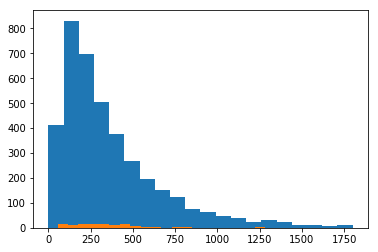

Predict the Help time!: 250
Your prediction: 250
Actual help time: 220
Error is: 13.636363636363635


In [40]:
game()

We played around for a while and started to get good at it.
Thats when we decided to go ahead and tried to model the poisson distribution. We asked a few TAs and searched on the internet about what we should do and decided to use a Generalized linear model with a link function suited to a poisson distribution in the end. 

## Creating the Model and Training

In order to create the training and test set and labels we remove the andrew IDs which have less than 10 entries in the dataset, because it is difficult to fit a distribution to such a small sample size.
We then  do a 70-30 data split

In [41]:
data = pd.get_dummies(df5['andrew_id_hash'])
data = data.drop([col for col, val in data.sum().iteritems() if val <= 10], axis=1)
data = data.join(pd.get_dummies(df5['new_id']))
data = data.join(df5['HT'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15533 entries, 0 to 15532
Columns: 373 entries, 006224cb5c837901ba7551f1b8d087c3c2fcdba3 to HT
dtypes: int32(1), uint8(372)
memory usage: 6.3 MB
None


In [42]:
datalen = data.shape[0]
np.random.seed(42)
perm = np.random.permutation(datalen)
train_idx = perm[:int(datalen*0.7)]
cv_idx = perm[int(datalen * 0.7):]

X_train = data.loc[train_idx, data.columns != 'HT']
y_train = data.loc[train_idx, ['HT']]
X_cv = data.loc[cv_idx, data.columns != 'HT']
y_cv = data.loc[cv_idx, ['HT']]
print(X_train.info())
print(y_train.info())
print(X_cv.info())
print(y_cv.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10873 entries, 10986 to 8891
Columns: 372 entries, 006224cb5c837901ba7551f1b8d087c3c2fcdba3 to written
dtypes: uint8(372)
memory usage: 3.9 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10873 entries, 10986 to 8891
Data columns (total 1 columns):
HT    10873 non-null int32
dtypes: int32(1)
memory usage: 127.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4660 entries, 3832 to 7270
Columns: 372 entries, 006224cb5c837901ba7551f1b8d087c3c2fcdba3 to written
dtypes: uint8(372)
memory usage: 1.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4660 entries, 3832 to 7270
Data columns (total 1 columns):
HT    4660 non-null int32
dtypes: int32(1)
memory usage: 54.6 KB
None


### A Failed Attempt

In [43]:
model = sm.GLM(y_train, X_train, family=sm.families.Poisson(statsmodels.genmod.families.links.log))
results = model.fit()

In [44]:
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     HT   No. Observations:                10873
Model:                            GLM   Df Residuals:                    10501
Model Family:                 Poisson   Df Model:                          371
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.3189e+06
Date:                Fri, 11 May 2018   Deviance:                   2.5553e+06
Time:                        22:33:35   Pearson chi2:                 2.98e+06
No. Iterations:                     6                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
006224cb5c837901ba7551f1b8d087c3c2fcdba3     0.2082      0.008     26.4

In [45]:
i = random.randint(0, X_train.shape[0])
rec = X_train.iloc[[i]]
label = y_train.iloc[[i]]
print("Actual help time: " + str(label['HT'].values[0]))
print("Predicted help time: " + str(results.predict(rec).values[0]))

Actual help time: 196
Predicted help time: 752.6903499088932


So initially, we tried this a lot of times but did not get good results. Thats when we realized an important mistake: we did  not divide our labels into time slots and were instead trying to predict discrete time values. (A bad idea)

### Testing the Waters with Timeslots

In [46]:
timeslot = 120
y2_train = y_train.apply(lambda x : x // timeslot)
print(y_train.head())
print(y2_train.head())

        HT
10986  296
8878   417
1346   254
2099   160
11498  201
       HT
10986   2
8878    3
1346    2
2099    1
11498   1


In [47]:
model = sm.GLM(y2_train, X_train, family=sm.families.Poisson(statsmodels.genmod.families.links.log))
results2 = model.fit()

In [48]:
print(results2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     HT   No. Observations:                10873
Model:                            GLM   Df Residuals:                    10501
Model Family:                 Poisson   Df Model:                          371
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -26945.
Date:                Fri, 11 May 2018   Deviance:                       26857.
Time:                        22:33:45   Pearson chi2:                 2.96e+04
No. Iterations:                     6                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
006224cb5c837901ba7551f1b8d087c3c2fcdba3     0.2534      0.090      2.8

We saw that the results had started getting better. 

In [57]:
i = random.randint(0, X_train.shape[0])
rec = X_train.iloc[[i]]
label = y_train.iloc[[i]]
print("Actual help time: " + str(label['HT'].values[0]))
print("Predicted help time: " + str(results2.predict(rec).values[0] * timeslot))

Actual help time: 367
Predicted help time: 476.63683045602164


## Cross Validation

All we needed to do now was fine tune our bin size. We decided to use vanillacross validation for this. 

In [50]:
def cross_validation(timeslots):
    for t in timeslots:
        
        # Training on the training set
        y2_train = y_train.apply(lambda x : x // t)
        model = sm.GLM(y2_train, X_train, family=sm.families.Poisson(statsmodels.genmod.families.links.log))
        res = model.fit()
        
        # Calculating error on the cross-validation set, cannot vectorize because predict doesn't work with multiple samples for some reason
        err = 0
        for i in range(len(X_cv)):
            rec = X_cv.iloc[[i]]
            label = y_cv.iloc[[i]]
            err += abs(res.predict(rec).values[0] * t - label.values[0])[0]
            
        # err2 = np.sum(abs(res.predict(X_cv) * t - y_cv))
            
        err /= len(X_cv)
        # err2 /= len(X_cv)
        
        print("Timeslot: " + str(t) + ". Average error per prediction in seconds: " + str(err))

Tested on different timeslots and did cross validation

In [51]:
tl_list = [1, 3, 10, 30, 60, 90, 120, 150, 180, 210, 240, 300]
tl_list2 = [180]
cross_validation(tl_list)

Timeslot: 1. Average error per prediction in seconds: 260.12836487465944
Timeslot: 3. Average error per prediction in seconds: 259.8675504174509
Timeslot: 10. Average error per prediction in seconds: 258.9855548588442
Timeslot: 30. Average error per prediction in seconds: 256.72383288110467
Timeslot: 60. Average error per prediction in seconds: 253.7744682183234
Timeslot: 90. Average error per prediction in seconds: 251.6224644782766
Timeslot: 120. Average error per prediction in seconds: 250.20106069233665
Timeslot: 150. Average error per prediction in seconds: 249.3368293624175
Timeslot: 180. Average error per prediction in seconds: 249.4269757875168
Timeslot: 210. Average error per prediction in seconds: 250.48618984412414
Timeslot: 240. Average error per prediction in seconds: 251.80115974019293
Timeslot: 300. Average error per prediction in seconds: 255.8779019995681


We observed that the minimum error occured on a timeslot of size 150 secs or 2.5 minutes. An error of approximately four minutes was great for our purposes. 

## Training final model

In [52]:
y2_train = y_train.apply(lambda x : x // 150)
model = sm.GLM(y2_train, X_train, family=sm.families.Poisson(statsmodels.genmod.families.links.log))
model_res = model.fit()

## Human VS Machine!

Ultimately, just for fun, we decided to create this game to let a user compete with our model.
After playing around with it for a while, we were very  pleased to see that our model was quite hard to beat. 

In [53]:
def human_vs_machine():
    
    idx = random.randint(0, len(X_cv))
    sample = X_cv.iloc[[idx]]
    label = y_cv.iloc[[idx]].values[0][0]
    
    machine_pred = model_res.predict(sample).values[0] * 150
    
    andrew = ""
    new_id = ""
    
    first = 0
    for col in sample:
        if (sample[col].values[0] == 1):
            if (first == 0):
                andrew = col
                first = 1
            else:
                new_id = col
                
    
    print("Helping " + andrew + " with " + new_id + "!")
    
    assignment_stats = df5['HT'].where(df5['new_id'] == new_id).dropna()
    plt.hist(assignment_stats, bins=20, range=(0,1800))
    
    person_stats = df5['HT'].where(df5['andrew_id_hash'] == andrew).dropna()
    plt.hist(person_stats, bins=20)
    
    plt.show()
    
    human_pred = int(input("Predict the Help time!: "))
    
    print("Your prediction: " + str(human_pred))
    print("Machine prediction: " + str(machine_pred))
    print("")
    print("Actual help time: " + str(label))
    print("")
    
    human_err = abs(human_pred-label)/label * 100
    machine_err = abs(machine_pred-label)/label * 100
    print("Human error : " + str(human_err))
    print("Machine error : " + str(machine_err))
    print("")
    
    if (human_err > machine_err):
        print("Machine wins!")
    else:
        print("You win!")
    

Helping ee9df52b8820e414b470c173f87d1f9191947508 with queues!


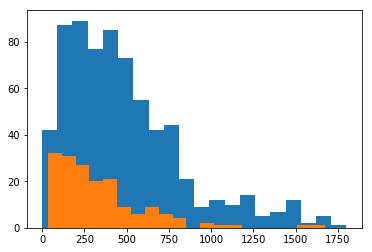

Predict the Help time!: 350
Your prediction: 350
Machine prediction: 308.5920857518558

Actual help time: 279

Human error : 25.448028673835125
Machine error : 10.60648234833541

Machine wins!


In [54]:
human_vs_machine()

Thus, ultimately, we ended up with a help time predictor that can be plugged as it is into the current 122 infrastructure for predicting wait times and performs significantly better than the current implementation in use. 

## Next Steps
1. We plan to try out other linear models and a few different sets of features to see if accuracy can be improved over what we have currently achieved. Being just freshman, we still have a lot to learn about this field and will continue working on this project and improving it as our knowledge base increases over the years.

2. We are also in talks with the 122 staff about incorporating this and potentially replacing the current prediction algorithm in use, into the OH queue system. This will allow students to get a better estimate of the time they will have to wait at an OH and thus manage their time better. 